# T1D Analysis 

Analysis with low-complexity filtered data.

In [1]:
import pandas as pd
import numpy as np
import os
import re
import xlsxwriter
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("S01_data.csv",usecols=["seq","strand"])
data["S01"] = 1
for x in range(2, 21):
    if x < 10:
        new_col = pd.read_csv(f"S0{x}_data.csv", usecols = ["seq","strand"])
        new_col[f"S0{x}"] = 1
    elif x == 15: #Sample 15 is a poor run, exclude from analysis
        continue
    else:
        new_col = pd.read_csv(f"S{x}_data.csv", usecols = ["seq","strand"])
        new_col[f"S{x}"] = 1
    data = data.merge(new_col, on=["seq","strand"], how="outer")

In [3]:
data = data.fillna(0)

In [4]:
data.head(5)

,seq,strand,S01,S02,S03,S04,S05,S06,S07,S08,...,S10,S11,S12,S13,S14,S16,S17,S18,S19,S20
0,GGACCGGCGCAAGACGGACCAGAGCGAAAGCATTTGCCAAGAATGTT,+,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,CATGACCCGCCGGGCAGCTTCCGGGAAACCAAAGTCTTTGGGTTCCG,+,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,GCGACCTCAGATCAGACGTGGCGACCCGCTGAATTTAAGCATATTAG,+,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,AGAGCGAAAGCATTTGCCAAGAATGTTTTCATT,+,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,CGCGACCTCAGATCAGACGTGGCGACCCGCTGAATTTAAGCATATTA,+,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [5]:
data.shape

(9374449, 21)

In [6]:
path = "Diabetic and Controls cfRNA.xlsx"
meta = pd.read_excel(path, sheet_name=None)
meta_data = meta["Samples 1 "]
meta_data = meta_data.drop(14)
meta_data

,Coded #,Sample Number,Control/T1D,Age Years,Gender
0,1,70.7,Control,11,M
1,2,103.0,T1D,15,F
2,3,63.0,T1D,5,F
3,4,43.0,Control,9,F
4,5,91.0,T1D,10,F
5,6,75.0,T1D,13,M
6,7,70.6,Control,6,F
7,8,70.2,Control,8,M
8,9,70.5,Control,4,F
9,10,45.0,T1D,9,F


In [7]:
data = data.set_index(["seq","strand"])

In [8]:
data.shape

(9374449, 19)

In [9]:
arrays = [list(meta_data["Control/T1D"]), list(data.columns)]
tuples = list(zip(*arrays))
control = [x[1] for x in tuples if x[0] == "Control"]
t1d = [x[1] for x in tuples if x[0] == "T1D"]

## Filter RNA species
Filter out all RNA species that are present in only one of the samples and all RNA species that are present in 3 or more control samples. 

In [10]:
def filter_ones_and_ctrl(row):
    count = 0
    for ctrl in control:
        count += row[ctrl]
    return count < 3 and np.sum(row) > 1

In [11]:
filter_data = data[data.apply(filter_ones_and_ctrl, axis=1)]

In [12]:
filter_data.shape

(1189748, 19)

In [13]:
filter_data.head(5)

,,S01,S02,S03,S04,S05,S06,S07,S08,S09,S10,S11,S12,S13,S14,S16,S17,S18,S19,S20
seq,strand,,,,,,,,,,,,,,,,,,,
CTATGAGTGACTACAAAAAGGATTAGACTGAGCTG,+,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
GGCAACAGAGTGGGATTCTGCCTC,+,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGTGTATGTTAGCAATGATG,+,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAGGTAGATAGCAACGCTGTTACTTCAAAATATATGCTACTTATGCA,-,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GGCAACAGAGTGGGATTCTGCCTC,-,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


After passing the data through the two filters, we reduce the number of RNA species from 9374449 to 1189748.

## Fisher's Exact Test and Visualizations
Fisher's Exact Test (one-sided)
<br/>Table from each row of data:
<pre>   [Diabetes Presence, Control Presence] 
   [Diabetes Absence, Control Absence]</pre>
S15 is excluded. Greater alternative hypothesis using scipy.stats.fisher_exact. 9 T1D samples and 10 control samples.

In [14]:
def fisher(row):
    ctrl_pres = 0
    t1d_pres = 0
    for ctrl in control:
        ctrl_pres += row[ctrl]
    for t in t1d:
        t1d_pres += row[t]
    oddsratio, pvalue = stats.fisher_exact([[t1d_pres, ctrl_pres], 
                                [9-t1d_pres, 10-ctrl_pres]], "greater")
    return pvalue

In [15]:
pvals = filter_data.apply(fisher,axis=1)

In [16]:
filter_data["pval"] = pvals

/avicenna/jwang/anaconda3/envs/smRNA/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
sig_data = filter_data[filter_data["pval"] <= 0.05]
sig_data.shape

(2377, 20)

In [18]:
sig_hmdata = sig_data.iloc[:,:19]
sig_hmdata.head(10)

,,S01,S02,S03,S04,S05,S06,S07,S08,S09,S10,S11,S12,S13,S14,S16,S17,S18,S19,S20
seq,strand,,,,,,,,,,,,,,,,,,,
CCGACCCGGGGAGGTAGTGAC,+,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
CACCGCCCGTCGCTACTACCGAT,+,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
CGACTCTTAGCGGTGGATCACTCGGCTAAGAGTCGATGAAGAACGCA,+,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
CGCGACCTCAGATCAGACATGGCGACCCGCTGAATTTAAGCATATTA,+,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
GAAAAAAAAGAGTATAGAATC,+,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
TGGGTCGGGGTTTCGTACGTAGCAGAGCAGCTCCCGCTGCGATCTAT,+,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
TGGCGGAGCGCTGAGAAGACGGTCGAACTTGACTATCTCGAGGAAGT,+,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ATATTAAAGTTGCTGCAGTT,+,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
AAACGGAGCAGGTCAAAACTCCCGTGCTGATCAGTAGTGGGATCGCG,-,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
sample_index = pd.MultiIndex.from_tuples(tuples)
indexed_sig_hmdata = pd.DataFrame(sig_hmdata.values, index=sig_hmdata.index, 
                                  columns=sample_index).sort_index(axis=1)

In [20]:
indexed_sig_hmdata

Control                 \
                                                           S01  S04  S07  S08   
seq                                             strand                          
CCGACCCGGGGAGGTAGTGAC                           +          1.0  0.0  0.0  0.0   
CACCGCCCGTCGCTACTACCGAT                         +          1.0  0.0  0.0  0.0   
CGACTCTTAGCGGTGGATCACTCGGCTAAGAGTCGATGAAGAACGCA +          1.0  0.0  0.0  0.0   
CGCGACCTCAGATCAGACATGGCGACCCGCTGAATTTAAGCATATTA +          1.0  0.0  0.0  0.0   
GAAAAAAAAGAGTATAGAATC                           +          1.0  0.0  0.0  0.0   
...                                                        ...  ...  ...  ...   
CTGAGCGACAGAGTGAGACTCCATCT                      +          0.0  0.0  0.0  0.0   
CGCAGCGGACGGAGGT                                +          0.0  0.0  0.0  0.0   
CTGGCGATGCGGGAT                                 +          0.0  0.0  0.0  0.0   
GGTGGGCGGGGAGCGG                                +          0.0  0.0  0.0  0.0   
GGAGAGGAAAAAAGG                                 +          0.0  0.0  0.0  0.0   

                                                                            \
                                                        S09  S11  S12  S14   
seq                                             strand                       
CCGACCCGGGGAGGTAGTGAC                           +       0.0  0.0  0.0  0.0   
CACCGCCCGTCGCTACTACCGAT                         +       1.0  0.0  0.0  0.0   
CGACTCTTAGCGGTGGATCACTCGGCTAAGAGTCGATGAAGAACGCA +       0.0  0.0  0.0  0.0   
CGCGACCTCAGATCAGACATGGCGACCCGCTGAATTTAAGCATATTA +       0.0  0.0  0.0  0.0   
GAAAAAAAAGAGTATAGAATC                           +       0.0  0.0  0.0  0.0   
...                                                     ...  ...  ...  ...   
CTGAGCGACAGAGTGAGACTCCATCT                      +       0.0  0.0  0.0  0.0   
CGCAGCGGACGGAGGT                                +       0.0  0.0  0.0  0.0   
CTGGCGATGCGGGAT                                 +       0.0  0.0  0.0  0.0   
GGTGGGCGGGGAGCGG                                +       0.0  0.0  0.0  0.0   
GGAGAGGAAAAAAGG                                 +       0.0  0.0  0.0  0.0   

                                                                  T1D       \
                                                        S16  S18  S02  S03   
seq                                             strand                       
CCGACCCGGGGAGGTAGTGAC                           +       0.0  0.0  1.0  1.0   
CACCGCCCGTCGCTACTACCGAT                         +       0.0  0.0  1.0  1.0   
CGACTCTTAGCGGTGGATCACTCGGCTAAGAGTCGATGAAGAACGCA +       0.0  0.0  1.0  1.0   
CGCGACCTCAGATCAGACATGGCGACCCGCTGAATTTAAGCATATTA +       0.0  1.0  1.0  1.0   
GAAAAAAAAGAGTATAGAATC                           +       1.0  0.0  1.0  1.0   
...                                                     ...  ...  ...  ...   
CTGAGCGACAGAGTGAGACTCCATCT                      +       0.0  0.0  0.0  0.0   
CGCAGCGGACGGAGGT                                +       0.0  0.0  0.0  0.0   
CTGGCGATGCGGGAT                                 +       0.0  0.0  0.0  0.0   
GGTGGGCGGGGAGCGG                                +       0.0  0.0  0.0  0.0   
GGAGAGGAAAAAAGG                                 +       0.0  0.0  0.0  0.0   

                                                                            \
                                                        S05  S06  S10  S13   
seq                                             strand                       
CCGACCCGGGGAGGTAGTGAC                           +       0.0  0.0  1.0  1.0   
CACCGCCCGTCGCTACTACCGAT                         +       0.0  1.0  1.0  1.0   
CGACTCTTAGCGGTGGATCACTCGGCTAAGAGTCGATGAAGAACGCA +       1.0  0.0  1.0  1.0   
CGCGACCTCAGATCAGACATGGCGACCCGCTGAATTTAAGCATATTA +       1.0  0.0  1.0  1.0   
GAAAAAAAAGAGTATAGAATC                           +       1.0  0.0  1.0  1.0   
...                                                     ...  ...  ...  ...   
CTGAGCGACAGAGTGAGACTCCATCT      

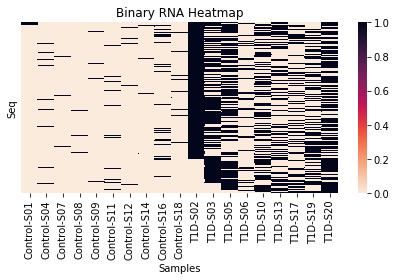

In [21]:
cmap = sns.cm.rocket_r
ax = sns.heatmap(indexed_sig_hmdata,yticklabels=False, vmin=0, vmax=1, cmap=cmap)
plt.xlabel("Samples")
plt.ylabel("Seq")
plt.title("Binary RNA Heatmap")
plt.tight_layout()
plt.savefig("Binary_RNA_heatmap.png");

In [22]:
countdata = pd.read_csv("S01_data.csv",usecols=["seq", "cpm","strand",])
countdata.columns = ["seq", "S01", "strand"]
for x in range(2, 21):
    if x < 10:
        new_col = pd.read_csv(f"S0{x}_data.csv", usecols = ["seq", "cpm","strand"])
        new_col.columns = ["seq", f"S0{x}","strand"]
    elif x == 15:
        continue
    else:
        new_col = pd.read_csv(f"S{x}_data.csv", usecols = ["seq", "cpm","strand"])
        new_col.columns = ["seq", f"S{x}", "strand"]
    countdata = countdata.merge(new_col, on=["seq","strand"], how="outer")

In [23]:
countdata = countdata.fillna(0)
countdata = countdata.set_index(["seq","strand"])
countdata.head(5)

,,S01,S02,S03,S04,S05,S06,S07,S08,S09,S10,S11,S12,S13,S14,S16,S17,S18,S19,S20
seq,strand,,,,,,,,,,,,,,,,,,,
GGACCGGCGCAAGACGGACCAGAGCGAAAGCATTTGCCAAGAATGTT,+,9191.378652,3194.071745,5254.088456,1957.244056,5516.369263,2463.613649,2215.962539,1871.947281,4873.735830,4528.788156,4461.099360,3702.115369,9507.797271,3691.096055,4150.771593,9246.483524,2968.650797,2209.658688,2558.314926
CATGACCCGCCGGGCAGCTTCCGGGAAACCAAAGTCTTTGGGTTCCG,+,6091.376073,3386.977883,5560.066985,3373.729969,8140.518677,10862.031811,616.890079,1012.899149,2353.559770,7752.651502,2531.953267,2230.850409,10527.940221,1773.926494,3669.886395,379.275845,3261.755650,4595.251422,3581.908969
GCGACCTCAGATCAGACGTGGCGACCCGCTGAATTTAAGCATATTAG,+,4675.124346,2159.640949,4351.694635,271.881177,4423.727740,2760.645082,666.172117,803.382037,1300.276884,5140.471660,1819.025704,1624.656079,5216.049383,898.128581,2749.085985,28.336701,2189.126871,2162.256769,2151.736759
AGAGCGAAAGCATTTGCCAAGAATGTTTTCATT,+,4631.672711,1618.595970,1348.248249,699.981374,1124.312292,273.734850,1127.434706,873.034588,1844.500951,1265.311021,4514.120289,3187.126570,3648.473034,1903.553299,3640.695281,1715.460286,2579.611954,568.823029,560.720439
CGCGACCTCAGATCAGACGTGGCGACCCGCTGAATTTAAGCATATTA,+,3888.921327,1931.330862,4034.059781,331.965416,3858.178297,2411.196338,562.420457,730.372736,1093.471739,5049.592968,1538.422636,1546.348301,4603.638726,793.011046,2637.442776,106.807565,2132.241389,1928.893475,1996.254119


In [24]:
filter_seq = filter_data.index 

In [25]:
filter_count_data = countdata.loc[filter_seq]

In [26]:
filter_count_data.head(5)

,,S01,S02,S03,S04,S05,S06,S07,S08,S09,S10,S11,S12,S13,S14,S16,S17,S18,S19,S20
seq,strand,,,,,,,,,,,,,,,,,,,
CTATGAGTGACTACAAAAAGGATTAGACTGAGCTG,+,28.515135,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.165111,0.0,0.0,0.0,0.0,0.0,0.0,7.713286,6.381028,18.765146
GGCAACAGAGTGGGATTCTGCCTC,+,10.862909,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,4.186339,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
AGTGTATGTTAGCAATGATG,+,9.505045,0.453897,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
CAGGTAGATAGCAACGCTGTTACTTCAAAATATATGCTACTTATGCA,-,9.505045,0.000000,0.0,0.0,0.0,0.0,0.0,0.279729,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
GGCAACAGAGTGGGATTCTGCCTC,-,8.147182,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,6.698142,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [27]:
#Max normalize for each row for visualization.
norm_data = filter_count_data.div(filter_count_data.max(axis=1), axis=0) 

In [28]:
norm_data = pd.DataFrame(norm_data.values, index=norm_data.index, columns=sample_index).sort_index(axis=1)

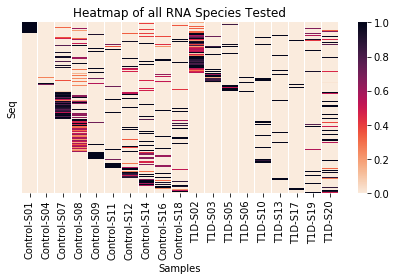

In [29]:
cmap = sns.cm.rocket_r
ax2 = sns.heatmap(norm_data,yticklabels=False,cmap=cmap)
plt.xlabel("Samples")
plt.ylabel("Seq")
plt.title("Heatmap of all RNA Species Tested")
plt.tight_layout()
plt.savefig("RNA_Tested_Heatmap");

In [30]:
sig_seq = sig_data.index

In [31]:
sig_count_data = countdata.loc[sig_seq]

In [32]:
#Max normalize for each row for visualization.
norm_sig_data = sig_count_data.div(sig_count_data.max(axis=1), axis=0) 

In [33]:
norm_sig_data = pd.DataFrame(norm_sig_data.values, index=norm_sig_data.index, columns=sample_index).sort_index(axis=1)

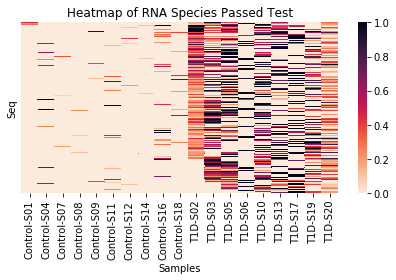

In [34]:
cmap = sns.cm.rocket_r
ax3 = sns.heatmap(norm_sig_data,yticklabels=False,cmap=cmap)
plt.xlabel("Samples")
plt.ylabel("Seq")
plt.title("Heatmap of RNA Species Passed Test")
plt.tight_layout()
plt.savefig("RNA_Passed_Heatmap");

## Annotations

In [55]:
samples = data.columns
bam_data = [pd.read_csv(f"{s}_data.csv", index_col=0).set_index(["seq","strand"]) for s in samples]

/avicenna/jwang/anaconda3/envs/smRNA/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [56]:
bam_data[0].head(5)

,,cpm,count,ref_id,start,end,len,mapflag
seq,strand,,,,,,,
GGACCGGCGCAAGACGGACCAGAGCGAAAGCATTTGCCAAGAATGTT,+,9191.378652,6769,chr21,8210599,8210646,47,True
CATGACCCGCCGGGCAGCTTCCGGGAAACCAAAGTCTTTGGGTTCCG,+,6091.376073,4486,chr21,8210747,8210794,47,True
GCGACCTCAGATCAGACGTGGCGACCCGCTGAATTTAAGCATATTAG,+,4675.124346,3443,chr21,8213888,8213935,47,True
AGAGCGAAAGCATTTGCCAAGAATGTTTTCATT,+,4631.672711,3411,chr14,16055553,16055586,33,True
CGCGACCTCAGATCAGACGTGGCGACCCGCTGAATTTAAGCATATTA,+,3888.921327,2864,chr21,8213887,8213934,47,True


In [65]:
bam_data[0].iloc[0].name

('GGACCGGCGCAAGACGGACCAGAGCGAAAGCATTTGCCAAGAATGTT', '+')

In [66]:
def addBed(row):
    bed = []
    for s in range(19):
        if row[s] > 0:
            sample = bam_data[s].loc[row.name]
            ref_id = sample["ref_id"]
            start = sample["start"]
            end = sample["end"]
            strand = sample.name[1]
            bed = f"{ref_id}\t{start}\t{end}\t.\t.\t{strand}"   
            return bed

In [67]:
bed_data = sig_data.apply(addBed, axis=1)

In [68]:
bed_data.head(5)

seq                                              strand
CCGACCCGGGGAGGTAGTGAC                            +         chr21\t8254336\t8254357\t.\t.\t+
CACCGCCCGTCGCTACTACCGAT                          +         chr21\t8211327\t8211350\t.\t.\t+
CGACTCTTAGCGGTGGATCACTCGGCTAAGAGTCGATGAAGAACGCA  +         chr21\t8439821\t8439869\t.\t.\t+
CGCGACCTCAGATCAGACATGGCGACCCGCTGAATTTAAGCATATTA  +         chr21\t8396925\t8396972\t.\t.\t+
GAAAAAAAAGAGTATAGAATC                            +         chr12\t9083731\t9083752\t.\t.\t+
dtype: object

In [69]:
bed_data.to_csv("sig_rna.bed",index=False, header=False)

In [70]:
#Of the 2377 "significant RNAs, 2366 are sequence unique."
len(bed_data.index.get_level_values(0).unique())

2366

In [81]:
%%bash
#Intersect with known smRNA
bedtools intersect -a sig_rna.bed -b /avicenna/genomes/hg38/hg38_smRNAs.bed -loj > T1D_smRNA_intersect.bed 

In [82]:
smRNA_intersect = pd.read_csv("T1D_smRNA_intersect.bed", header=None, sep="\t")

In [84]:
smRNA_intersect = smRNA_intersect[smRNA_intersect[6] != "."]

In [87]:
smRNA_intersect.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11
11,chr11,62853907,62853948,.,.,-,chr11,62853903,62853968,U29,1,-
12,chr11,93732364,93732411,.,.,-,chr11,93732360,93732499,ACA8,1,-
18,chr19,49490615,49490662,.,.,+,chr19,49490616,49490699,U33,1,+
19,chr19,49490907,49490954,.,.,+,chr19,49490906,49490972,U34,1,+
29,chr1,121020771,121020801,.,.,-,chr1,121020728,121020801,tRNA-Val-CAC-5-1,1,-


In [88]:
smRNA_intersect.shape

(246, 12)

In [89]:
smRNA_intersect.to_csv("smRNA_intersect.csv")

In [90]:
%%bash
#Intersect with known genes
 bedtools intersect -a sig_rna.bed -b /avicenna/genomes/hg38/gencode.v28.annotation.gff3.gz -loj > T1D_genes_intersect.bed 

In [91]:
genes_intersect = pd.read_csv("T1D_genes_intersect.bed", header=None, sep="\t")

In [92]:
genes_intersect = genes_intersect[genes_intersect[6] != "."]

In [93]:
genes_intersect.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,chr21,8211327,8211350,.,.,+,chr21,HAVANA,gene,8197620,8227646,.,+,.,ID=ENSG00000278996.1;gene_id=ENSG00000278996.1...
2,chr21,8211327,8211350,.,.,+,chr21,HAVANA,transcript,8197620,8227646,.,+,.,ID=ENST00000623664.1;Parent=ENSG00000278996.1;...
3,chr21,8439821,8439869,.,.,+,chr21,ENSEMBL,gene,8439823,8439975,.,+,.,ID=ENSG00000278189.1;gene_id=ENSG00000278189.1...
4,chr21,8439821,8439869,.,.,+,chr21,ENSEMBL,transcript,8439823,8439975,.,+,.,ID=ENST00000619471.1;Parent=ENSG00000278189.1;...
5,chr21,8439821,8439869,.,.,+,chr21,ENSEMBL,exon,8439823,8439975,.,+,.,ID=exon:ENST00000619471.1:1;Parent=ENST0000061...


In [96]:
genes_intersect.shape

(11339, 15)

In [97]:
genes_intersect.to_csv("genes_intersect.csv")

Of the 2377 RNA species that passed our Fisher Test filter, there were 246 overlaps with known smRNAs and 11339 overlaps with known genes.

## Export Data

In [53]:
sig_count_data.to_csv("sig_RNA_count.csv")

In [54]:
countdata.to_csv("total_RNA_count.csv")